In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sedol-symbology/sedol_mapping_raw.parquet
/kaggle/input/sedol-symbology/sp500_constituents.parquet


## 1. Load the data 

### Loading the data

In [2]:
import os
import re
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# ------------------------------
# Files listing (your original)
# ------------------------------
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# ------------------------------
# Load original parquet files (your original)
# ------------------------------
sedol_mapping = pd.read_parquet('/kaggle/input/sedol-symbology/sedol_mapping_raw.parquet')
sp500_constituents = pd.read_parquet('/kaggle/input/sedol-symbology/sp500_constituents.parquet')

/kaggle/input/sedol-symbology/sedol_mapping_raw.parquet
/kaggle/input/sedol-symbology/sp500_constituents.parquet


In [3]:
# ------------------------------------------------
# QUESTION 1
# -------------------------------------------------
conn = sqlite3.connect(':memory:')
c = conn.cursor()

# push normalized tables to sqlite
sedol_mapping.to_sql('sedol_mapping', conn, if_exists='replace', index=False)
sp500_constituents.to_sql('sp500_constituents', conn, if_exists='replace', index=False)

c.execute("DROP TABLE IF EXISTS output")
c.execute("""
CREATE TABLE output AS
SELECT
    s.date AS date,
    s.index_name AS index_name,
    s.sedol AS sedol,
    s.security_name AS security_name,
    s.price AS price,
    s.weight AS weight,
    m.adia_id AS adia_id,
    m.start_date AS start_date,
    m.end_date AS end_date
FROM sp500_constituents s
LEFT JOIN sedol_mapping m
    ON s.sedol = m.sedol
   AND date(s.date) >= date(m.start_date)
   AND date(s.date) < date(m.end_date)
""")
conn.commit()

c.execute("SELECT COUNT(*) FROM output")
print("Rows in output table (Q1):", c.fetchone()[0])

#check how many rows have missing adia_id
c.execute(" SELECT COUNT(*) FROM output WHERE adia_id IS NULL OR TRIM(adia_id) = '' ")
print("Rows with missing adia_id:", c.fetchone()[0])

Rows in output table (Q1): 698151
Rows with missing adia_id: 1769


In [ ]:
# import pandas as pd

# # Load output table into a DataFrame
# df_output = pd.read_sql_query("SELECT * FROM output", conn)

# # Export to CSV
# df_output.to_csv("output_table_oldest.csv", index=False)

# # Check how many rows got exported
# print("CSV exported successfully with", len(df_output), "rows.")
# print(df_output.head())  # optional: preview first 5 rows

### Basic EDA checks for sedol_mapping_raw & sp500_constituents constituents before joining

In [4]:
# sedol_mapping_raw
print("Shape:", sedol_mapping.shape)
print("\nColumns:", sedol_mapping.columns.tolist())
print("\nData Types:\n", sedol_mapping.dtypes)
print("\nMissing Values:\n", sedol_mapping.isnull().sum())
print("\nUnique Value Counts:\n", sedol_mapping.nunique())
print("\nBasic Statistics:\n", sedol_mapping.describe())
print("\nSample Rows:\n", sedol_mapping.sample(5, random_state=42))
print("\nDuplicates in sedol_mapping_raw:", sedol_mapping.duplicated().sum())
print("\nValue Counts per Column:")
for col in sedol_mapping.columns:
    print(f"\n{col}:\n", sedol_mapping[col].value_counts(dropna=False).head())

Shape: (3645, 4)

Columns: ['sedol', 'adia_id', 'start_date', 'end_date']

Data Types:
 sedol                 object
adia_id               object
start_date    datetime64[ns]
end_date      datetime64[ns]
dtype: object

Missing Values:
 sedol         0
adia_id       0
start_date    0
end_date      0
dtype: int64

Unique Value Counts:
 sedol         700
adia_id       683
start_date    280
end_date      325
dtype: int64

Basic Statistics:
                           start_date                       end_date
count                           3645                           3645
mean   2016-11-05 10:35:39.259259136  2017-09-25 00:18:57.777777920
min              2015-01-01 00:00:00            2015-01-21 00:00:00
25%              2015-02-19 00:00:00            2016-01-01 00:00:00
50%              2017-01-01 00:00:00            2017-11-07 00:00:00
75%              2018-01-01 00:00:00            2019-01-01 00:00:00
max              2019-12-09 00:00:00            2020-01-01 00:00:00

Sample Rows:
 

In [5]:
# sp500_constituents
print("Shape:", sp500_constituents.shape)
print("\nColumns:", sp500_constituents.columns.tolist())
print("\nData Types:\n", sp500_constituents.dtypes)
print("\nMissing Values:\n", sp500_constituents.isnull().sum())
print("\nUnique Value Counts:\n", sp500_constituents.nunique())
print("\nBasic Statistics:\n", sedol_mapping.describe())
print("\nSample Rows:\n", sp500_constituents.sample(5, random_state=42))
print("\nDuplicates in sp500_constituents:", sp500_constituents.duplicated().sum())
print("\nValue Counts per Column:")
for col in sp500_constituents.columns:
    print(f"\n{col}:\n", sp500_constituents[col].value_counts(dropna=False).head())

Shape: (634721, 6)

Columns: ['date', 'index_name', 'sedol', 'security_name', 'price', 'weight']

Data Types:
 date             datetime64[ns]
index_name               object
sedol                    object
security_name            object
price                   float64
weight                  float64
dtype: object

Missing Values:
 date              0
index_name        0
sedol            19
security_name     0
price             0
weight            0
dtype: int64

Unique Value Counts:
 date               1258
index_name            1
sedol               700
security_name       750
price             47486
weight           634720
dtype: int64

Basic Statistics:
                           start_date                       end_date
count                           3645                           3645
mean   2016-11-05 10:35:39.259259136  2017-09-25 00:18:57.777777920
min              2015-01-01 00:00:00            2015-01-21 00:00:00
25%              2015-02-19 00:00:00            2016-01-01 0

In [6]:
print("\nMissing Values:\n", sp500_constituents.isnull().sum())


Missing Values:
 date              0
index_name        0
sedol            19
security_name     0
price             0
weight            0
dtype: int64


In [7]:
# 634721 rows
sp500_constituents = sp500_constituents.dropna(subset=["sedol"]).copy()

# Check result
print(f"Remaining rows: {sp500_constituents.shape[0]}")

Remaining rows: 634702


In [8]:
print("\nMissing Values:\n", sp500_constituents.isnull().sum())


Missing Values:
 date             0
index_name       0
sedol            0
security_name    0
price            0
weight           0
dtype: int64


In [9]:
# Converting to datetime
sedol_mapping["start_date"] = pd.to_datetime(sedol_mapping["start_date"], errors="coerce")

# Extracting year
sedol_mapping["year"] = sedol_mapping["start_date"].dt.year

# Function to check valid adia_id
def is_valid_adia(x):
    if pd.isna(x) or x.strip() == "":
        return False
    # Must be alphanumeric, at least 5 chars
    return bool(re.match(r"^[A-Z0-9]{5,}$", str(x).upper()))

# Flag garbage
sedol_mapping["is_garbage"] = ~sedol_mapping["adia_id"].astype(str).apply(is_valid_adia)

# Group by year to see garbage values
garbage_summary = sedol_mapping.groupby("year")["is_garbage"].sum().reset_index(name="garbage_count")

print("---- Garbage Records ----")
print(sedol_mapping[sedol_mapping["is_garbage"]])

print("\n---- Garbage Count per Year ----")
print(garbage_summary)

---- Garbage Records ----
        sedol   adia_id start_date   end_date  year  is_garbage
3205  2417578      None 2016-02-15 2016-03-10  2016        True
3206  2036070      Null 2016-05-01 2016-05-25  2016        True
3207  2429090        ** 2016-08-10 2016-08-10  2016        True
3208  2684703           2016-07-12 2016-07-30  2016        True
3209  B4V9661         A 2016-06-01 2016-06-15  2016        True
3211  BDV82B8           2016-09-01 2016-09-05  2016        True
3212  BFRT3W7         ? 2016-11-15 2016-12-01  2016        True
3213  2445966      Null 2016-10-10 2016-10-20  2016        True
3215  2536763         * 2016-12-01 2016-12-10  2016        True
3216  BLS09M3      None 2016-06-25 2016-06-25  2016        True
3217  2023607         - 2016-01-20 2016-02-10  2016        True
3218  2420101         0 2016-05-01 2016-05-15  2016        True
3219  2219224      test 2016-02-15 2016-03-01  2016        True
3220  2636607         ? 2016-04-10 2016-04-20  2016        True
3222  2304227 

In [10]:
# Remove garbage rows - 54 count
sedol_mapping = sedol_mapping[~sedol_mapping["is_garbage"]].copy()

# Check result, shape changed after deletion
sedol_mapping.shape

(3591, 6)

### Data Validation and Joining

In [11]:
# ADDED: Normalize SEDOLs & parse dates ( for joins and checks)
sedol_mapping['sedol'] = sedol_mapping['sedol'].astype(str).str.strip().str.upper()
sp500_constituents['sedol'] = sp500_constituents['sedol'].astype(str).str.strip().str.upper()
sedol_mapping['start_date'] = pd.to_datetime(sedol_mapping['start_date'])
sedol_mapping['end_date']   = pd.to_datetime(sedol_mapping['end_date'])
sp500_constituents['date']  = pd.to_datetime(sp500_constituents['date'])

In [12]:
sedol_mapping.dtypes

sedol                 object
adia_id               object
start_date    datetime64[ns]
end_date      datetime64[ns]
year                   int32
is_garbage              bool
dtype: object

In [13]:
sp500_constituents.dtypes

date             datetime64[ns]
index_name               object
sedol                    object
security_name            object
price                   float64
weight                  float64
dtype: object

In [ ]:
# import pandas as pd

# # Load output table into a DataFrame
# df_output = pd.read_sql_query("SELECT * FROM output", conn)

# # Export to CSV
# df_output.to_csv("output_table_old.csv", index=False)

# # Check how many rows got exported
# print("CSV exported successfully with", len(df_output), "rows.")
# print(df_output.head())  # optional: preview first 5 rows

### 2.Data issues in the three years 2015-2018 

<!-- Garbage values in adia_id have already been flagged and identified above -->

In [ ]:
# Garbage values in adia_id have already been flagged and identified above

In [ ]:
# Since garbage values are a small percentage, dropping those rows and also drop the helper columns is_garbage & year and saving the cleaned file.

In [ ]:
# Issues per year (2015–2018) mentioned at the end of this answer post additional verifications

In [14]:
#Running code and saving corrected file in sedol_mapping_corrected
# Remove garbage rows
sedol_mapping_corrected = sedol_mapping[~sedol_mapping["is_garbage"]].drop(columns=["is_garbage"]).copy()

print(f"Original rows: {sedol_mapping.shape[0]}")
print(f"Garbage removed: {sedol_mapping['is_garbage'].sum()}")
print(f"Cleaned rows: {sedol_mapping_corrected.shape[0]}")

Original rows: 3591
Garbage removed: 0
Cleaned rows: 3591


In [ ]:
# sedol_mapping_corrected.dtypes

In [15]:
# Extract year from start_date
sedol_mapping_corrected["year"] = sedol_mapping_corrected["start_date"].dt.year

# Flag invalid ranges
sedol_mapping_corrected["invalid_range"] = sedol_mapping_corrected["start_date"] > sedol_mapping_corrected["end_date"]

# Count invalids per year
invalid_summary = (
    sedol_mapping_corrected.groupby("year")["invalid_range"]
    .sum()
    .reset_index(name="invalid_count")
)

print("---- Invalid Ranges per Year ----")
print(invalid_summary)

print("\n---- Rows with Invalid Ranges ----")
print(sedol_mapping_corrected[sedol_mapping_corrected["invalid_range"]])

---- Invalid Ranges per Year ----
   year  invalid_count
0  2015              0
1  2016              0
2  2017              0
3  2018              0
4  2019              0

---- Rows with Invalid Ranges ----
Empty DataFrame
Columns: [sedol, adia_id, start_date, end_date, year, invalid_range]
Index: []


In [16]:
sedol_mapping_corrected.columns

Index(['sedol', 'adia_id', 'start_date', 'end_date', 'year', 'invalid_range'], dtype='object')

In [ ]:
# sedol_mapping_corrected.dtypes

In [17]:
# Drop invalid_range & year columns
sedol_mapping_corrected = sedol_mapping_corrected.drop(columns=["invalid_range","year"], errors="ignore")

# Confirm
print(sedol_mapping_corrected.columns)

Index(['sedol', 'adia_id', 'start_date', 'end_date'], dtype='object')


In [18]:
sedol_mapping_corrected.dtypes

sedol                 object
adia_id               object
start_date    datetime64[ns]
end_date      datetime64[ns]
dtype: object

In [19]:
# Convert to datetime type
# sedol_mapping['sedol'] = sedol_mapping['sedol'].astype(str).str.strip().str.upper()
# sedol_mapping["start_date"] = pd.to_datetime(sedol_mapping["start_date"], errors="coerce")
# sedol_mapping["end_date"] = pd.to_datetime(sedol_mapping["end_date"], errors="coerce")

# 1. Missing values
missing_dates = sedol_mapping_corrected[sedol_mapping_corrected["start_date"].isna() | sedol_mapping_corrected["end_date"].isna()]

# 2. Start date after end date
invalid_ranges = sedol_mapping_corrected[sedol_mapping_corrected["start_date"] > sedol_mapping_corrected["end_date"]]

# 3. Summary report
print("---- Data Type Check ----")
print(sedol_mapping_corrected.dtypes)

print("\n---- Missing Dates ----")
print(missing_dates if not missing_dates.empty else " No missing dates")

print("\n---- Invalid Date Ranges (start > end) ----")
print(invalid_ranges if not invalid_ranges.empty else "All ranges are valid")

---- Data Type Check ----
sedol                 object
adia_id               object
start_date    datetime64[ns]
end_date      datetime64[ns]
dtype: object

---- Missing Dates ----
 No missing dates

---- Invalid Date Ranges (start > end) ----
All ranges are valid


In [20]:
print(sedol_mapping_corrected.columns)
print(sedol_mapping_corrected.shape)

Index(['sedol', 'adia_id', 'start_date', 'end_date'], dtype='object')
(3591, 4)


In [21]:
sedol_mapping_corrected.dtypes

sedol                 object
adia_id               object
start_date    datetime64[ns]
end_date      datetime64[ns]
dtype: object

In [ ]:
# SQL query to re-check the data again

In [22]:
sedol_mapping_corrected.to_sql("sedol_mapping_corrected", conn, if_exists="replace", index=False)

# 3. Now run your query
query = """
SELECT
    strftime('%Y', start_date) AS year,
    COUNT(*) AS invalid_count
FROM sedol_mapping_corrected
WHERE adia_id IS NULL
   OR TRIM(adia_id) = ''
   OR adia_id IN ('UNKNOWN', 'PLACEHOLDER', 'EXAMPLE')
   OR adia_id GLOB '*[^A-Z0-9]*'
   OR LENGTH(adia_id) < 6
   OR LENGTH(adia_id) > 10
   OR start_date > end_date
GROUP BY strftime('%Y', start_date)
ORDER BY strftime('%Y', start_date);
"""

df = pd.read_sql_query(query, conn)

print(df)

   year  invalid_count
0  2016             11


In [23]:
# checking the invalid rows
# Query to fetch all invalid rows
invalid_rows_query = """
SELECT *
FROM sedol_mapping_corrected
WHERE adia_id IS NULL
   OR TRIM(adia_id) = ''
   OR adia_id IN ('UNKNOWN', 'PLACEHOLDER', 'EXAMPLE')
   OR adia_id GLOB '*[^A-Z0-9]*'
   OR LENGTH(adia_id) < 6
   OR LENGTH(adia_id) > 10
   OR start_date > end_date
ORDER BY start_date;
"""

# Read the invalid rows into a DataFrame
invalid_rows_df = pd.read_sql_query(invalid_rows_query, conn)

# Display the invalid rows
print(invalid_rows_df)

      sedol         adia_id           start_date             end_date
0   2896713        Mdk83Dis  2016-01-20 00:00:00  2016-02-01 00:00:00
1   2261021        owe283DJ  2016-02-15 00:00:00  2016-02-25 00:00:00
2   B5LL299           12321  2016-03-05 00:00:00  2016-03-15 00:00:00
3   2380863  94835849684392  2016-03-10 00:00:00  2016-03-20 00:00:00
4   2762030    AKSBFHDIWUEJ  2016-03-15 00:00:00  2016-03-20 00:00:00
5   2636254     placeholder  2016-04-20 00:00:00  2016-05-01 00:00:00
6   2299011         example  2016-06-05 00:00:00  2016-06-20 00:00:00
7   2550161        dusjwied  2016-06-10 00:00:00  2016-06-15 00:00:00
8   B0X7DZ3         UNKNOWN  2016-07-01 00:00:00  2016-07-15 00:00:00
9   2318024        nnnnnnnn  2016-07-01 00:00:00  2016-07-15 00:00:00
10  2210614        mD3hfs83  2016-11-01 00:00:00  2016-11-05 00:00:00


In [24]:
print("Current rows:", len(sedol_mapping_corrected))

Current rows: 3591


In [25]:
# list of further identified garbage adia_id values that I want to drop
garbage_ids = [
    "Mdk83Dis", "owe283DJ", "12321","94835849684392","AKSBFHDIWUEJ","placeholder", 
    "example","dusjwied","UNKNOWN", "nnnnnnnn", "mD3hfs83"
]

# drop rows where adia_id matches any in garbage_ids (case insensitive)
sedol_mapping_corrected = sedol_mapping_corrected[
    ~sedol_mapping_corrected["adia_id"].str.lower().isin([x.lower() for x in garbage_ids])
].copy()

# reset index
sedol_mapping_corrected.reset_index(drop=True, inplace=True)

In [26]:
#those 11 garbage values removed above
print("Remaining rows:", len(sedol_mapping_corrected))

Remaining rows: 3580


In [ ]:
# sedol_mapping_corrected.dtypes

In [ ]:
# # manual check to see all rows & columns of sedol_mapping_corrected
# pd.set_option("display.max_rows", None)
# pd.set_option("display.max_columns", None)
# print(sedol_mapping_corrected)

In [ ]:
# Additional Checks for data problems in sedol_mapping_raw.parquet

In [27]:
# ADDED: Basic detection checks
inverted = sedol_mapping_corrected['end_date'] < sedol_mapping_corrected['start_date']
print("Inverted intervals:", inverted.sum())   # expect 0 ideally

exact_dupes = sedol_mapping_corrected.duplicated(subset=['sedol','start_date','end_date','adia_id'])
print("Exact duplicates:", exact_dupes.sum())

conflicts = sedol_mapping_corrected.groupby(['sedol','start_date','end_date'])['adia_id'].nunique()
print("Conflicting triplets (same interval, multiple adia_id):", (conflicts>1).sum())

Inverted intervals: 0
Exact duplicates: 302
Conflicting triplets (same interval, multiple adia_id): 0


In [28]:
# Check for sedols in constituents missing from mapping
mapping_sedols = set(sedol_mapping_corrected['sedol'].unique())
const_sedols = set(sp500_constituents['sedol'].dropna().unique())
missing_in_mapping = sorted(list(const_sedols - mapping_sedols))

print("Missing sedols in mapping:", len(missing_in_mapping))
print("Sample missing sedols:", missing_in_mapping[:10] if len(missing_in_mapping) > 0 else [])

Missing sedols in mapping: 0
Sample missing sedols: []


In [ ]:
# sedol_mapping_corrected.dtypes

In [29]:
# Drop exact duplicates based on ['sedol','start_date','end_date','adia_id']
before = len(sedol_mapping_corrected)
sedol_mapping_corrected = sedol_mapping_corrected.drop_duplicates(
    subset=['sedol','start_date','end_date','adia_id']
).reset_index(drop=True)
after = len(sedol_mapping_corrected)

print(f"Dropped exact duplicates: {before - after}")
print(f"Rows after dropping duplicates: {after}")

Dropped exact duplicates: 302
Rows after dropping duplicates: 3278


In [ ]:
# sedol_mapping_corrected.dtypes

In [ ]:
# 2015: Clean data; no garbage adia_ids or invalid date ranges

# 2016: Multiple garbage/placeholder adia_ids (~60 rows) and some invalid entries; removed garbage and duplicates.

# 2017: Clean data; all adia_ids and date ranges valid.

# 2018: Clean data; all adia_ids and date ranges valid.

In [ ]:
#other necessary cleaning steps performed above as part of Q1 & Q2

# Dropped missing SEDOLs from sp500_constituents (19 rows).

# Converted date columns to datetime (start_date, end_date, date).

# Extracted year from start_date for analysis.

# Validated adia_id using regex: alphanumeric, length.

# Flagged garbage/placeholder adia_ids (None, Null, **, A, ?, placeholder, example, UNKNOWN, etc.).

# Dropped garbage rows from sedol_mapping.

# Manually removed remaining invalid adia_ids from a predefined list.

# Dropped exact duplicates based on ['sedol','start_date','end_date','adia_id'].

# Checked and confirmed no inverted intervals (start_date > end_date).

# Normalized SEDOLs (stripped whitespace, uppercase) for consistent joins.

# Verified all SEDOLs in constituents exist in mapping.

# Created output table via SQLite join using latest start_date and exclusive end_date.

# SQL validation: ensured no invalid adia_ids, no missing mappings, and valid intervals.

In [ ]:
# Save corrected file
# sedol_mapping_corrected.to_parquet("sedol_mapping_corrected.parquet", index=False)

In [30]:
#running pipeline again after cleaning the data
import sqlite3

# Use clear names for DataFrames
df_sedol_cleaned = sedol_mapping_corrected  
df_constituents = sp500_constituents        

# Connect to SQLite in-memory
conn = sqlite3.connect(':memory:')
c = conn.cursor()

# Push cleaned tables to SQLite with clear table names
df_sedol_cleaned.to_sql('sedol_mapping_corrected', conn, if_exists='replace', index=False)  
df_constituents.to_sql('sp500_constituents', conn, if_exists='replace', index=False)

# Drop existing output table if it exists
c.execute("DROP TABLE IF EXISTS output")

# Run the mapping pipeline
c.execute("""
CREATE TABLE output AS
SELECT
    s.date AS date,
    s.index_name AS index_name,
    s.sedol AS sedol,
    s.security_name AS security_name,
    s.price AS price,
    s.weight AS weight,
    m.adia_id AS adia_id,
    m.start_date AS start_date,
    m.end_date AS end_date
FROM sp500_constituents s
LEFT JOIN sedol_mapping_corrected m
    ON s.sedol = m.sedol
   AND date(s.date) >= date(m.start_date)
   AND date(s.date) < date(m.end_date)
""")

conn.commit()

# Check output rows
c.execute("SELECT COUNT(*) FROM output")
print("Rows in output table post data cleaning:", c.fetchone()[0])

Rows in output table post data cleaning: 634702


In [31]:
# check how many rows have missing adia_id
c.execute("SELECT COUNT(*) FROM output WHERE adia_id IS NULL OR TRIM(adia_id) = '' ")
print("Rows with missing adia_id:", c.fetchone()[0])

Rows with missing adia_id: 1713


In [ ]:
# Rows in output table old: 698151
# Rows with missing adia_id old: 1769
# Rows in output table post cleaning: 634702
# Rows with missing adia_id post cleaning & joining: 1713

In [ ]:
#Loading output to pandas for further cleaning

In [ ]:
#null value analysis in adia_id

In [32]:
import pandas as pd

# Load output table into a DataFrame
df_output = pd.read_sql_query("SELECT * FROM output", conn)

print("Output shape:", df_output.shape)
print("Null counts per column:\n", df_output.isna().sum())

Output shape: (634702, 9)
Null counts per column:
 date                0
index_name          0
sedol               0
security_name       0
price               0
weight              0
adia_id          1713
start_date       1713
end_date         1713
dtype: int64


In [33]:
df_output.dtypes

date              object
index_name        object
sedol             object
security_name     object
price            float64
weight           float64
adia_id           object
start_date        object
end_date          object
dtype: object

In [34]:
#changing to datetime column again as it was pushed to SQL DB and taken back again
df_output['start_date'] = pd.to_datetime(df_output['start_date'])
df_output['end_date']   = pd.to_datetime(df_output['end_date'])
df_output['date']  = pd.to_datetime(df_output['date'])

In [35]:
df_output.dtypes

date             datetime64[ns]
index_name               object
sedol                    object
security_name            object
price                   float64
weight                  float64
adia_id                  object
start_date       datetime64[ns]
end_date         datetime64[ns]
dtype: object

In [36]:
mask_adia_null = (
    df_output["adia_id"].isna() |
    df_output["adia_id"].astype(str).str.strip().eq("")
)

# --- Top securities with NULL adia_id ---
top_missing_securities = (
    df_output.loc[mask_adia_null, "security_name"]
    .value_counts()
    .rename_axis("security_name")
    .reset_index(name="missing_rows")
)
print("\nTop securities with NULL adia_id:")
print(top_missing_securities.head(10))


Top securities with NULL adia_id:
             security_name  missing_rows
0               CBS CORP B            27
1              RED HAT INC            27
2        CIMAREX ENERGY CO            26
3  AMERICAN ELECTRIC POWER            24
4         CAMPBELL SOUP CO            24
5          ROSS STORES INC            23
6         WYNN RESORTS LTD            23
7                 MYLAN NV            23
8               FISERV INC            22
9               NETAPP INC            22


In [ ]:
#top 10 securities with null adia_id

In [37]:
# Parse date and extract year
df_output["date_parsed"] = pd.to_datetime(df_output["date"], errors="coerce")
df_output["year"] = df_output["date_parsed"].dt.year

# Count missing by year (and overall denominator for rate)
denom = df_output.groupby("year", dropna=False).size().reset_index(name="total_rows_year")
numer = (
    df_output.loc[mask_adia_null]
    .groupby("year", dropna=False)
    .size()
    .reset_index(name="missing_rows_year")
)

missing_by_year = denom.merge(numer, on="year", how="left").fillna({"missing_rows_year": 0})
missing_by_year["missing_rows_year"] = missing_by_year["missing_rows_year"].astype(int)
missing_by_year["missing_rate_%"] = (
    missing_by_year["missing_rows_year"] / missing_by_year["total_rows_year"] * 100
).round(4)
missing_by_year = missing_by_year.sort_values("year")

print("\nMissing adia_id by year:")
print(missing_by_year)


Missing adia_id by year:
   year  total_rows_year  missing_rows_year  missing_rate_%
0  2015           126710                 27          0.0213
1  2016           127204                 31          0.0244
2  2017           126762               1609          1.2693
3  2018           126760                 28          0.0221
4  2019           127266                 18          0.0141


In [ ]:
#year 2017 has most missing adia_id

In [ ]:
# #checking rows with missing adia_id
# c.execute("""
# SELECT *
# FROM output
# WHERE adia_id IS NULL OR TRIM(adia_id) = ''
# """)

# missing_rows = c.fetchall()

# # Display the rows
# for row in missing_rows:
#     print(row)

In [ ]:
# import pandas as pd

# # Load output table into a DataFrame
# df_output = pd.read_sql_query("SELECT * FROM output", conn)

# # Export to CSV
# df_output.to_csv("output_table_new.csv", index=False)

# # Check how many rows got exported
# print("CSV exported successfully with", len(df_output), "rows.")
# print(df_output.head())  # optional: preview first 5 rows

Since doing signal analysis from 2018–2020, I am focusing only on handling null values within this period. For these years, I’m filtering out nulls to ensure cleaner analysis. For other years nulls will be treated differently—for example, by carrying forward the latest available date—since completely removing them would cause major data loss and hinder meaningful analysis

In [38]:
result = pd.read_sql_query('''
    SELECT * FROM output
    WHERE date >= '2018-01-01' AND date <= '2020-01-01' and adia_id is not null
''', conn)

# Calculate signal
price_threshold = 20
result = result[result['price'] > price_threshold]
result['signal_score'] = result.groupby(['adia_id'])['weight'].transform(
    lambda x: (x - x.mean()) / x.std()
)

print("Task 3: Sample of result with signal_score:")
display(result.head())

Task 3: Sample of result with signal_score:


,date,index_name,sedol,security_name,price,weight,adia_id,start_date,end_date,signal_score
0,2019-06-10 00:00:00,S&P 500,2520153,AGILENT TECHNOLOGIES INC,70.29,0.000928,9CDDCF1F,2019-01-01 00:00:00,2020-01-01 00:00:00,-0.372500
1,2018-04-26 00:00:00,S&P 500,2520153,AGILENT TECHNOLOGIES INC,66.37,0.000942,9CDDCF1F,2018-01-01 00:00:00,2019-01-01 00:00:00,-0.144120
2,2019-04-26 00:00:00,S&P 500,2520153,AGILENT TECHNOLOGIES INC,77.42,0.001004,9CDDCF1F,2019-01-01 00:00:00,2020-01-01 00:00:00,0.841684
3,2019-01-07 00:00:00,S&P 500,2520153,AGILENT TECHNOLOGIES INC,66.85,0.000996,9CDDCF1F,2019-01-01 00:00:00,2020-01-01 00:00:00,0.715735
4,2019-11-18 00:00:00,S&P 500,BCV7KT2,AMERICAN AIRLINES GROUP INC.,28.60,0.000437,04071152,2019-01-01 00:00:00,2020-01-01 00:00:00,-1.186945


In [39]:
result.shape

(241966, 10)

In [40]:
result.isnull().sum()

date             0
index_name       0
sedol            0
security_name    0
price            0
weight           0
adia_id          0
start_date       0
end_date         0
signal_score     9
dtype: int64

In [ ]:
#for these 9 securties we have only single entry, there is no variance ,hence they are getting signal score as null,the % is less hence dropping them

In [41]:
counts = result['adia_id'].value_counts()
singletons = counts[counts == 1].index
print("adia_ids with only 1 row:", list(singletons))

adia_ids with only 1 row: ['4376B348', '9268EE52', '97606A15', 'D81EB92D', '6A807CF7', 'EE22EEF2', '914B57A5', 'EC727FDF', '4D596C48']


In [42]:
# dropping 9 rows as 
result = result.dropna(subset=['signal_score'])

In [43]:
result.isnull().sum()

date             0
index_name       0
sedol            0
security_name    0
price            0
weight           0
adia_id          0
start_date       0
end_date         0
signal_score     0
dtype: int64

In [ ]:
result.dtypes

In [44]:
result['start_date'] = pd.to_datetime(result['start_date'])
result['end_date']   = pd.to_datetime(result['end_date'])
result['date']  = pd.to_datetime(result['date'])

In [45]:
result.dtypes

date             datetime64[ns]
index_name               object
sedol                    object
security_name            object
price                   float64
weight                  float64
adia_id                  object
start_date       datetime64[ns]
end_date         datetime64[ns]
signal_score            float64
dtype: object

### Analysis

In [ ]:
# so basically the above signal_score is telling how far a company’s index weight on a given day is from its own 2-year normal (2018-20) here
# Positive signal tell the stock is overweight vs its own history
# Negative tells the stock is underweight vs its own history
# the above signals as per formula above are ok for reporting 
# Good for tracking a single stock over time but cant compare different stocks on the same day
# it can have issues like outliers,nulls or zero variance(for 9 rows I found that)

In [ ]:
# EXAMPLE
# Agilent Technologies Inc (adia_id 9CDDCF1F) on 2019-04-26 had weight 0.001004 and signal_score ≈ +0.842, which is above its 2-year average.
# Negative: American Airlines Group Inc. (adia_id 04071152) on 2019-11-18 had weight 0.000437 and signal_score ≈ −1.187 which is below its 2-year average.

In [ ]:
# Outlier Detection

In [46]:
# outliers in different settings
# A) if a stock is unusual vs its own past
result['is_outlier_ts_weight'] = result['signal_score'].abs() > 3

# B) if a stock is unusual vs all stocks today,cross sectional, |z|>3 -> outlier
def cs_z_per_date(g):
    w = g['weight']
    mu, sd = w.mean(), w.std(ddof=1)
    g['cs_z'] = (w - mu) / sd if sd>0 else 0.0
    return g
result = result.groupby('date', group_keys=False).apply(cs_z_per_date)
result['is_outlier_cs_weight'] = result['cs_z'].abs() > 3

# C) if a stock’s price history has weird ticks (Tukey)
def iqr_flags(g, col='price', k=1.5):
    q1, q3 = g[col].quantile([0.25, 0.75])
    iqr = q3 - q1
    lo, hi = q1 - k*iqr, q3 + k*iqr
    g['is_outlier_price_iqr'] = (g[col] < lo) | (g[col] > hi)
    return g
result = result.groupby('adia_id', group_keys=False).apply(iqr_flags, col='price', k=1.5)

# Quick summary
out_summary = pd.Series({
    'ts_weight_z>|3|': int(result['is_outlier_ts_weight'].sum()),
    'cs_weight_z>|3|': int(result['is_outlier_cs_weight'].sum()),
    'price_IQR':      int(result['is_outlier_price_iqr'].sum())
})
print(out_summary)

ts_weight_z>|3|     168
cs_weight_z>|3|    4928
price_IQR          2489
dtype: int64


In [ ]:
# A clean-up method for outliers according to me (subject to adjustment by domain experts) is:
# Drop rows that trigger two or more outlier flags.
# Cap the remaining weights cross-sectionally (winsorize) and also cap signal_score at ±3.
# For prices cap extreme values or leave them unchanged, focusing the treatment on weights and signals.

In [ ]:
#Winsorization for capping values

In [47]:
def winsorize_series(s, lower=0.01, upper=0.99):
    lo, hi = s.quantile([lower, upper])
    return s.clip(lo, hi)

# Example: winsorize weights and signal_score
result['weight_winz'] = winsorize_series(result['weight'], 0.01, 0.99)
result['signal_winz'] = result['signal_score'].clip(-3, 3)   # cap at ±3

In [48]:
def cs_winsor(g, col='weight', p=(0.01,0.99)):
    lo, hi = g[col].quantile(p)
    g[col+'_winz'] = g[col].clip(lo, hi)
    return g

result = result.groupby('date', group_keys=False).apply(cs_winsor, col='weight', p=(0.01,0.99))

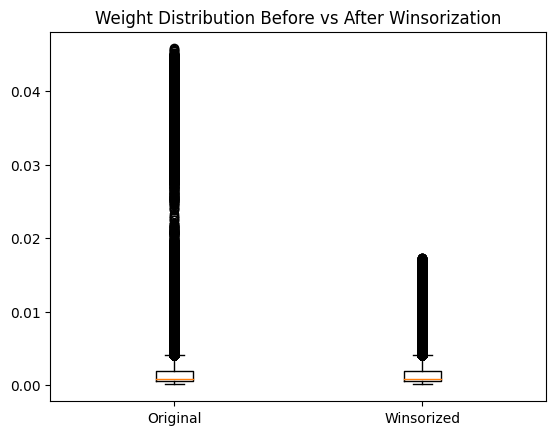

In [49]:
plt.boxplot([result['weight'], result['weight_winz']], labels=['Original','Winsorized'])
plt.title('Weight Distribution Before vs After Winsorization')
plt.show()

In [50]:
summary_check = {
    "weight_min": result["weight_winz"].min(),
    "weight_max": result["weight_winz"].max(),
    "signal_min": result["signal_winz"].min(),
    "signal_max": result["signal_winz"].max(),
    "weights_outside_bounds": ((result["weight_winz"] < result["weight_winz"].quantile(0.01)) | 
                               (result["weight_winz"] > result["weight_winz"].quantile(0.99))).sum(),
    "signals_outside_±3": (result["signal_winz"].abs() > 3).sum()
}

print("Post-winsorization check:")
for k, v in summary_check.items():
    print(f"{k}: {v}")

Post-winsorization check:
weight_min: 0.00016259026261199584
weight_max: 0.01725863653928123
signal_min: -3.0
signal_max: 3.0
weights_outside_bounds: 4833
signals_outside_±3: 0


-- Things for the getting more robust signals

1. Signals should be comparable across all stocks on the same day,so we can standardize them into things like cross-sectional z-scores.

2. Outliers:Some stocks have extreme values (outliers), or not enough data, we can cap them with winsorization(example above),also we can use median absolute deviation instead of just standard deviation

3.No single signal is perfect, we can try combinations like different window lengths (3months vs 6 months vs. 1 year) as signal that still works under many configurations is more reliable.
 
4.Dim & fact tables can be created for accurate joining/mapping to map data correctly over time.
  Also we can add a mapping detector if adia_id switches

In [ ]:
# Insights 

In [51]:
# Use the de-outliered version for rankings, here I’ll use result_no_outliers if it exists for the insight parts
_base = locals().get('result_no_outliers', result)

# Top 10 by average index weight
top10_weight = (_base.groupby(['adia_id','security_name'])['weight']
                     .mean()
                     .sort_values(ascending=False)
                     .head(10)
                     .reset_index())
print("\nTop 10 by Avg Weight:\n", top10_weight)

# Top 10 by average price
top10_price = (_base.groupby(['adia_id','security_name'])['price']
                    .mean()
                    .sort_values(ascending=False)
                    .head(10)
                    .reset_index())
print("\nTop 10 by Avg Price:\n", top10_price)

# Top 10 by average (absolute) signal_score -> strongest deviations vs own history
top10_abs_signal = (_base.assign(abs_sig=_base['signal_score'].abs())
                         .groupby(['adia_id','security_name'])['abs_sig']
                         .mean()
                         .sort_values(ascending=False)
                         .head(10)
                         .reset_index())
print("\nTop 10 by Mean |signal_score|:\n", top10_abs_signal)

# Top 10 by frequency of 'overweight' days (signal > 0)
top10_pct_pos = (_base.assign(pos=(_base['signal_score']>0).astype(int))
                      .groupby(['adia_id','security_name'])['pos']
                      .mean()
                      .mul(100)
                      .sort_values(ascending=False)
                      .head(10)
                      .reset_index(name='pct_positive_days'))
print("\nTop 10 by % Positive Signal Days:\n", top10_pct_pos)


Top 10 by Avg Weight:
     adia_id         security_name    weight
0  19FE06DF            APPLE INC.  0.038530
1  49C3B8E3        MICROSOFT CORP  0.037209
2  4739F999        AMAZON.COM INC  0.029453
3  0E1A2CC6        FACEBOOK INC A  0.017774
4  3D4D5D7B  BERKSHIRE HATHAWAY B  0.016789
5  3A2B3D71  JP MORGAN CHASE & CO  0.015716
6  6AC83CF8     JOHNSON & JOHNSON  0.015063
7  030D080C        ALPHABET INC C  0.014747
8  CDBE691D        ALPHABET INC A  0.014524
9  EDBA2D18      EXXON MOBIL CORP  0.013710

Top 10 by Avg Price:
     adia_id                security_name        price
0  CB8CB2DC                      NVR INC  3700.003284
1  87CAE620         BOOKING HOLDINGS INC  1923.330516
2  87CAE620      THE PRICELINE GROUP INC  1878.240789
3  4739F999               AMAZON.COM INC  1715.606133
4  CDBE691D               ALPHABET INC A  1156.699016
5  030D080C               ALPHABET INC C  1150.883817
6  32908C31                 AUTOZONE INC   891.712883
7  93ACD511          METTLER-TOLEDO I

,value
count,2.419570e+05
mean,5.274221e-17
std,9.988959e-01
skew,1.777545e-01
kurtosis_excess,-6.029451e-01
pct_|z|>=1,3.613163e+01
pct_|z|>=2,2.864972e+00
pct_|z|>=3,6.943383e-02


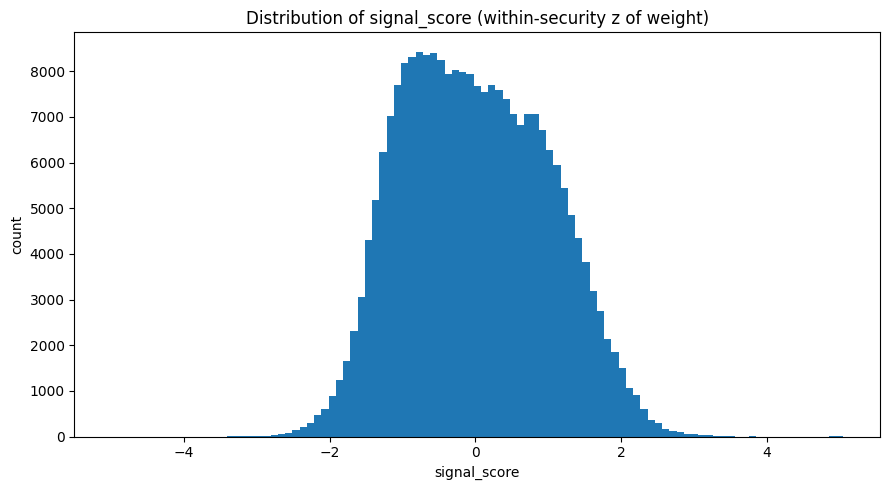

In [52]:
# 1) distribution
sig = result['signal_score'].dropna()
dist_summary = pd.Series({
    'count': sig.size,
    'mean': sig.mean(),
    'std': sig.std(ddof=1),
    'skew': sig.skew(),
    'kurtosis_excess': sig.kurtosis(),
    'pct_|z|>=1': (sig.abs()>=1).mean()*100,
    'pct_|z|>=2': (sig.abs()>=2).mean()*100,
    'pct_|z|>=3': (sig.abs()>=3).mean()*100
}).to_frame('value')
display(dist_summary)

plt.figure(figsize=(9,5))
plt.hist(sig, bins=101)
plt.title('Distribution of signal_score (within-security z of weight)')
plt.xlabel('signal_score'); plt.ylabel('count')
plt.tight_layout(); plt.show()

In [53]:
pn_overall = (result
    .assign(pos = (result['signal_score']>0).astype(int),
            neg = (result['signal_score']<0).astype(int))
    .groupby(['adia_id','security_name'])[['pos','neg']]
    .mean()
    .rename(columns={'pos':'pct_pos','neg':'pct_neg'})
    .mul(100)
    .reset_index()
)
# top names by % positive
display(pn_overall.sort_values('pct_pos', ascending=False).head(15))

,adia_id,security_name,pct_pos,pct_neg
485,D95AE2BE,VIACOMCBS INC B,100.000000,0.000000
256,6E238B4B,LINDE PLC,100.000000,0.000000
364,A35D84EA,WAL-MART STORES,100.000000,0.000000
215,5ADE6A6B,LEUCADIA NATIONAL CORP (NY),100.000000,0.000000
103,310B8408,ZIONS BANCORP (UT),100.000000,0.000000
45,167E8EF1,HEALTHPEAK PROPERTIES INC.,100.000000,0.000000
69,1D7318E9,L3HARRIS TECHNOLOGIES INC,100.000000,0.000000
1,00BBE07F,TRUIST FINANCIAL CORP,100.000000,0.000000
148,422882AE,KLA CORPORATION,100.000000,0.000000
183,4EA6DFF0,NEWMONT GOLDCORP CORP,100.000000,0.000000


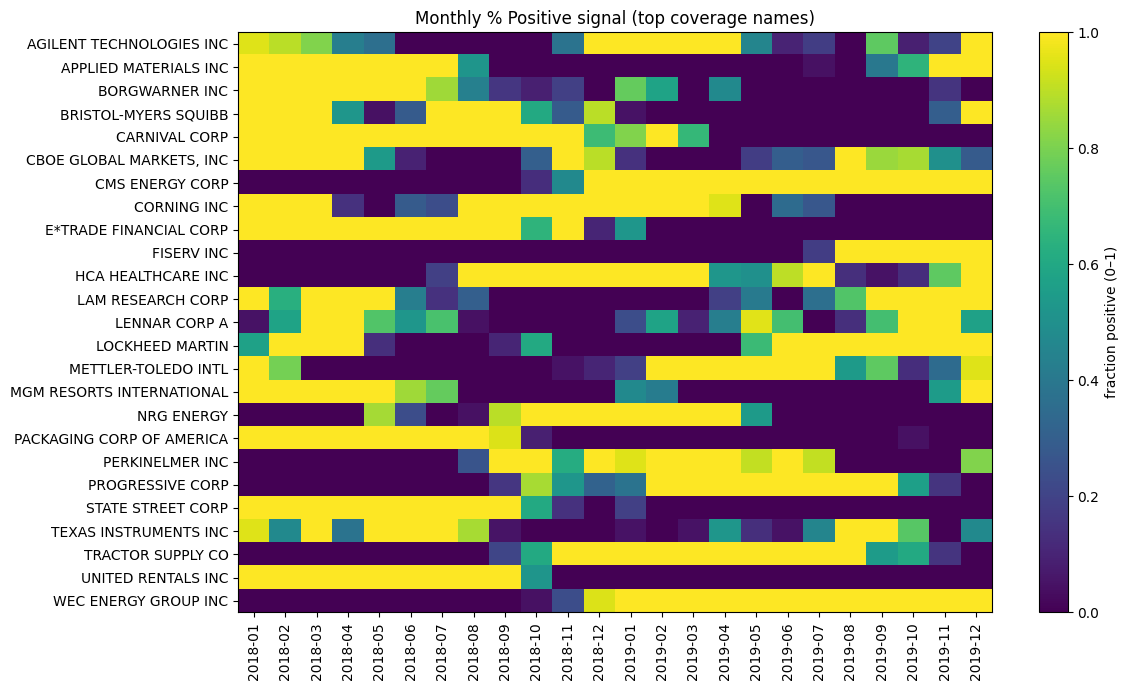

In [54]:
N = 25
coverage = result.groupby(['adia_id','security_name']).size().sort_values(ascending=False).head(N).index
top_ids = [k[0] for k in coverage]
top_names = {k[0]:k[1] for k in coverage}

tmp = result[result['adia_id'].isin(top_ids)].copy()
tmp['ym'] = tmp['date'].dt.to_period('M').astype(str)
heat = (tmp.assign(pos = (tmp['signal_score']>0).astype(int))
           .groupby(['security_name','ym'])['pos'].mean().unstack(fill_value=0).sort_index())
plt.figure(figsize=(12,7))
plt.imshow(heat.values, aspect='auto')
plt.yticks(range(heat.shape[0]), heat.index)
plt.xticks(range(heat.shape[1]), heat.columns, rotation=90)
plt.title('Monthly % Positive signal (top coverage names)')
plt.colorbar(label='fraction positive (0–1)')
plt.tight_layout(); plt.show()

In [55]:
def cs_z(group):
    x = group['weight'].values
    mu = np.nanmean(x); sd = np.nanstd(x, ddof=1)
    z = (x-mu)/sd if sd>0 else np.zeros_like(x)
    group['cs_z'] = z
    return group

cs = result.groupby('date', group_keys=False).apply(cs_z)
# correlation between within-name z (your signal) and cross-sectional z
corr_w_cs = cs[['signal_score','cs_z']].dropna().corr().iloc[0,1]
print('Correlation(signal_score, cross-sectional z) =', round(float(corr_w_cs), 3))

Correlation(signal_score, cross-sectional z) = 0.056


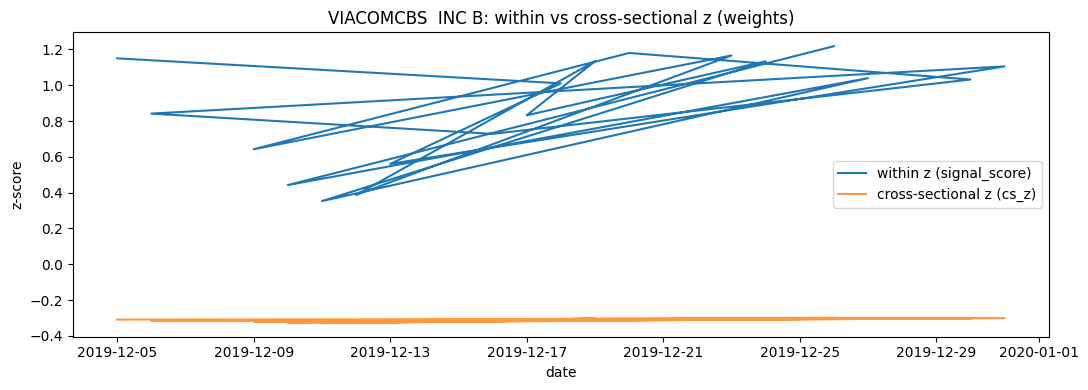

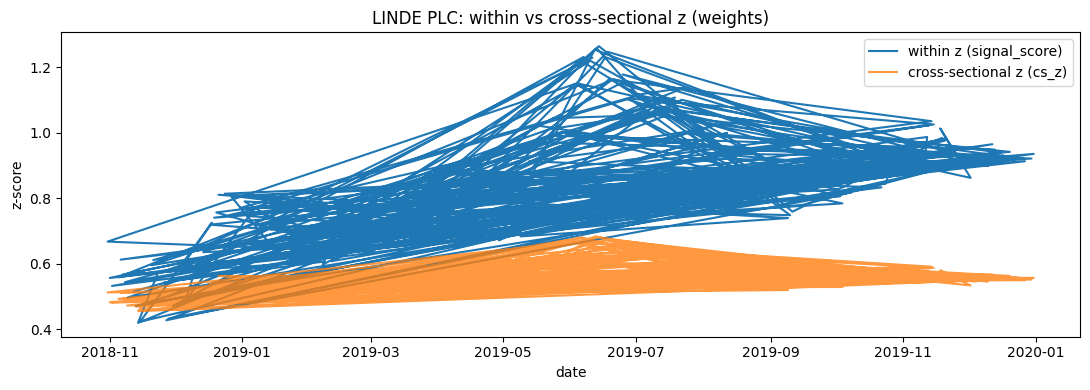

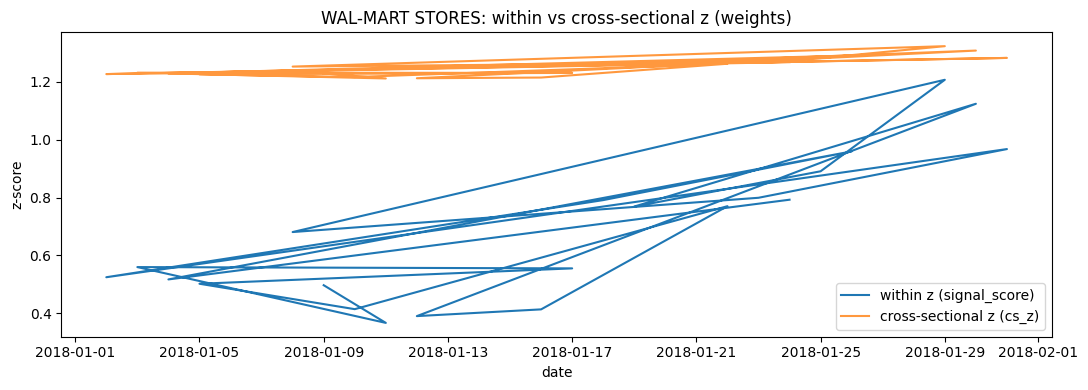

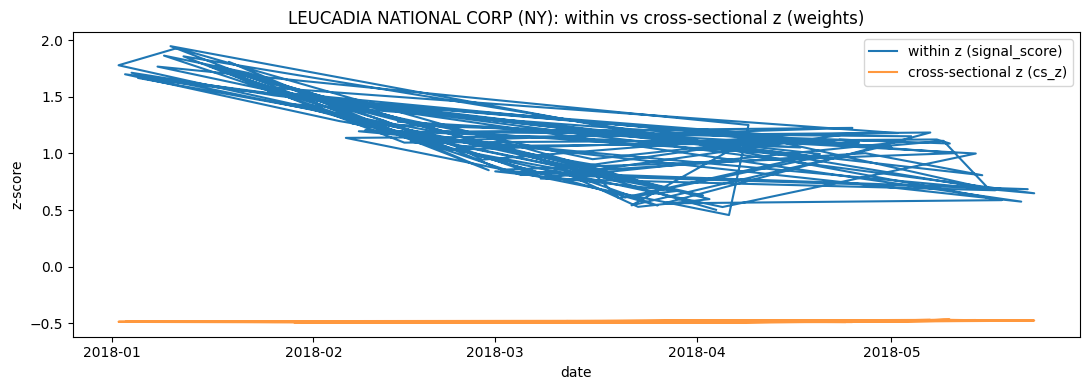

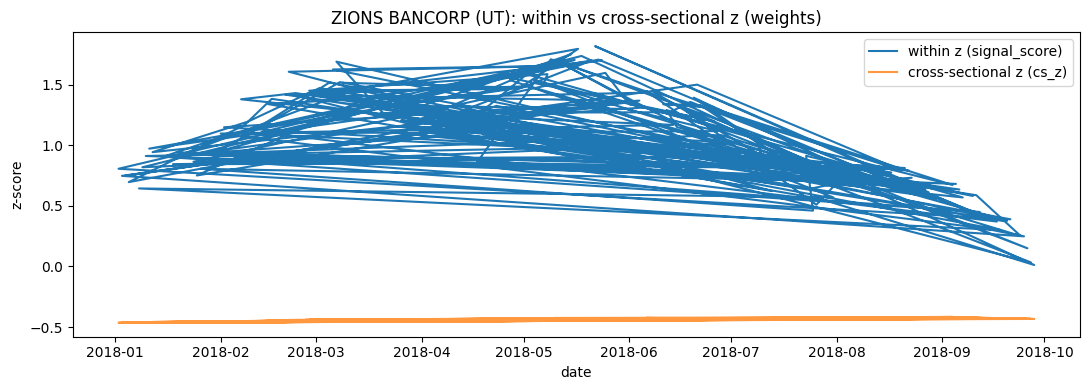

In [56]:
watch = pn_overall.sort_values('pct_pos', ascending=False)['security_name'].head(5).tolist()
compare = cs[cs['security_name'].isin(watch)].copy()
for nm in watch:
    sub = compare[compare['security_name']==nm]
    plt.figure(figsize=(11,4))
    plt.plot(sub['date'], sub['signal_score'], label='within z (signal_score)')
    plt.plot(sub['date'], sub['cs_z'], label='cross-sectional z (cs_z)', alpha=0.8)
    plt.title(f'{nm}: within vs cross-sectional z (weights)')
    plt.xlabel('date'); plt.ylabel('z-score'); plt.legend()
    plt.tight_layout(); plt.show()

In [57]:
ext = result[result['signal_score'].abs()>=2].copy()
print('Extreme events (|z|>=2):', len(ext))

# forward reversion: avg z after extremes at t+5,10,20 business days
def forward_avg(df, k):
    s = df.set_index('date')['signal_score'].sort_index()
    return s.shift(-k).reindex(s.index).mean()

fwd = []
for k in [5,10,20]:
    fwd.append(ext.groupby('adia_id').apply(lambda d: forward_avg(d[['date','signal_score']], k)).mean())
fwd_df = pd.DataFrame({'horizon_days':[5,10,20], 'avg_future_z_after_extreme': fwd})
display(fwd_df)

Extreme events (|z|>=2): 6932


,horizon_days,avg_future_z_after_extreme
0,5,0.812569
1,10,0.807821
2,20,0.536166


In [58]:
result['ret_1d'] = (result.sort_values(['adia_id','date'])
                           .groupby('adia_id')['price']
                           .pct_change())
# contemporaneous and lead/lag correlations per security
def corr_pair(s1, s2):
    s = pd.concat([s1, s2], axis=1).dropna()
    if len(s)<30: return np.nan
    return s.corr().iloc[0,1]

rels = (result.groupby('adia_id')
        .apply(lambda g: pd.Series({
            'corr(ret_1d, signal)': corr_pair(g['ret_1d'], g['signal_score']),
            'corr(lead_ret_1d, signal)': corr_pair(g['ret_1d'].shift(-1), g['signal_score']),
            'corr(lag_ret_1d, signal)': corr_pair(g['ret_1d'].shift(1), g['signal_score']),
        }))
        .reset_index())
display(rels.sort_values('corr(lead_ret_1d, signal)', ascending=False).head(15))

,adia_id,"corr(ret_1d, signal)","corr(lead_ret_1d, signal)","corr(lag_ret_1d, signal)"
210,6618B201,0.424878,0.267094,-0.013396
456,DC8E640A,0.014321,0.200379,0.202094
515,F91469D8,0.263420,0.158042,0.043167
195,5A99CBBF,0.108222,0.130422,0.094609
379,B993A395,0.010307,0.124965,-0.143575
465,E087A245,0.072858,0.117735,0.033434
496,F0216BA6,0.070792,0.115675,-0.116958
348,A7788F89,0.114111,0.115261,0.124486
26,0D4942E4,0.050464,0.110061,-0.026920
274,81F2DB94,0.048196,0.108148,0.073308


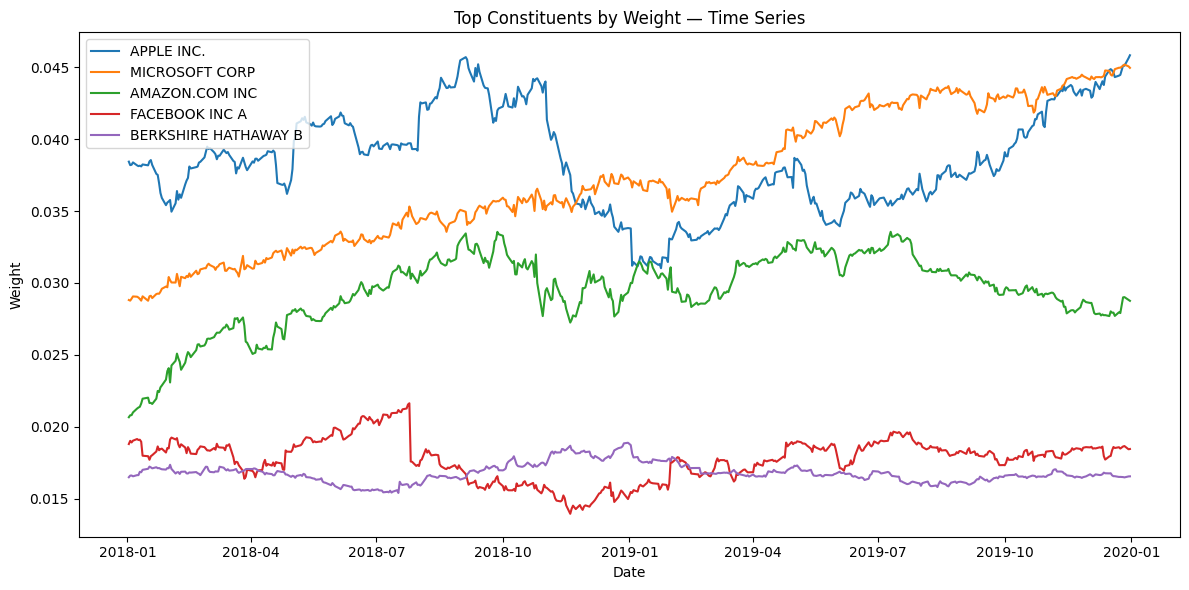

In [59]:
import matplotlib.pyplot as plt

# Top 5 by avg weight, then plot their weight over time
top5_names = top10_weight['security_name'].head(5).tolist()
plot_data = _base[_base['security_name'].isin(top5_names)].copy()
plot_data = plot_data.sort_values('date')

plt.figure(figsize=(12,6))
for nm in top5_names:
    sub = plot_data[plot_data['security_name']==nm]
    plt.plot(sub['date'], sub['weight'], label=nm)
plt.title('Top Constituents by Weight — Time Series')
plt.xlabel('Date'); plt.ylabel('Weight'); plt.legend()
plt.tight_layout(); plt.show()

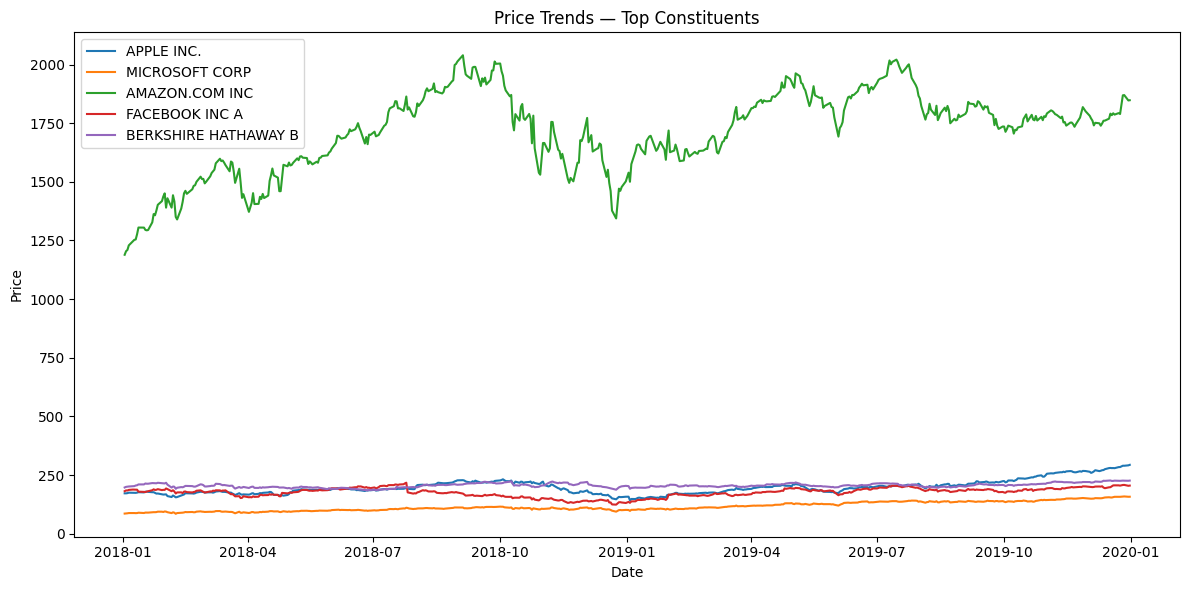

In [60]:
plt.figure(figsize=(12,6))
for nm in top5_names:
    sub = plot_data[plot_data['security_name']==nm]
    plt.plot(sub['date'], sub['price'], label=nm)
plt.title('Price Trends — Top Constituents')
plt.xlabel('Date'); plt.ylabel('Price')
plt.legend(); plt.tight_layout(); plt.show()

In [61]:
def longest_streak(x):
    # x is boolean series
    best = cur = 0
    prev = False
    for v in x:
        if v:
            cur = cur+1 if prev else 1
        else:
            cur = 0
        best = max(best, cur)
        prev = v
    return best

streaks = (result.assign(pos = result['signal_score']>0,
                         neg = result['signal_score']<0)
                 .groupby(['adia_id','security_name'])
                 .agg(pos_streak=('pos', longest_streak),
                      neg_streak=('neg', longest_streak))
                 .reset_index())
display(streaks.sort_values('pos_streak', ascending=False).head(15))
display(streaks.sort_values('neg_streak', ascending=False).head(15))

,adia_id,security_name,pos_streak,neg_streak
256,6E238B4B,LINDE PLC,293,0
103,310B8408,ZIONS BANCORP (UT),188,0
183,4EA6DFF0,NEWMONT GOLDCORP CORP,178,0
173,49DABADD,ARTHUR J. GALLAGHER & CO,173,1
69,1D7318E9,L3HARRIS TECHNOLOGIES INC,128,0
148,422882AE,KLA CORPORATION,118,0
215,5ADE6A6B,LEUCADIA NATIONAL CORP (NY),99,0
39,12D69C54,DOWDUPONT INC.,43,3
170,48C7444D,SCHEIN HENRY INC,41,2
45,167E8EF1,HEALTHPEAK PROPERTIES INC.,39,0


,adia_id,security_name,pos_streak,neg_streak
68,1D7318E9,HARRIS CORP,0,375
61,1AEA072A,CAPRI HOLDINGS LTD,0,252
257,6E238B4B,PRAXAIR INC,0,210
413,BE578B7C,CHARLES SCHWAB CORP,0,201
40,12D69C54,DUPONT DE NEMOURS INC.,0,148
341,98872288,W.W. GRAINGER INC,1,122
169,48C7444D,HENRY SCHEIN INC,1,114
465,D23F99E8,TECHNIPFMC PLC,0,114
184,4EA6DFF0,NEWMONT MINING CORP,1,99
296,81F2DB94,J.B. HUNT TRANSPORT SERVICES,1,93
